In [2]:
# Import libraries for data processing, visualization, and machine learning
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
# Upload the loan_data.csv file
from google.colab import files
uploaded = files.upload()

# Load the dataset into a pandas DataFrame
df = pd.read_csv('loan_data.csv')

# Display the first 5 rows to check the data
df.head()

Saving loan_data.csv to loan_data (1).csv


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001,Male,Yes,0,Graduate,No,5849,1468,128.36,360,1.0,Semiurban,Y
1,LP002,Male,No,1,Graduate,No,6091,1593,NaN,180,1.0,Urban,Y
2,LP003,Female,Yes,0,Not Graduate,Yes,3003,512,NaN,360,1.0,Rural,N
3,LP004,Male,Yes,2,Graduate,No,6715,1832,173.22,360,1.0,Semiurban,Y
4,LP005,Male,No,0,Graduate,Yes,4950,1251,125.78,360,0.0,Urban,N


In [4]:
# Check for missing values in each column
print("Missing Values in Each Column:")
print(df.isnull().sum())

Missing Values in Each Column:
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           2
Loan_Amount_Term     0
Credit_History       1
Property_Area        0
Loan_Status          0
dtype: int64


Real-world datasets often have missing values (e.g., blank entries). We need to check how many missing values each column has to decide how to handle them later. This is part of Phase 1: Data Preprocessing.

In [5]:
# Drop Loan_ID (not useful for prediction)
df = df.drop('Loan_ID', axis=1)

# Fill missing values
# Categorical columns: fill with mode (most frequent value)
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

# Numerical columns: fill with mean
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean(), inplace=True)

# Verify no missing values remain
print("Missing Values After Filling:")
print(df.isnull().sum())

Missing Values After Filling:
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


/tmp/ipython-input-5-1395184334.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
/tmp/ipython-input-5-1395184334.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

We’ll remove Loan_ID (it’s just an identifier, not useful for prediction) and fill missing values. For categorical columns (Gender, Married, etc.), we’ll use the most common value (mode). For numerical columns (LoanAmount, Loan_Amount_Term), we’ll use the average (mean).

In [6]:
# Encode categorical variables
# Binary categories: use LabelEncoder
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])  # Male=1, Female=0
df['Married'] = le.fit_transform(df['Married'])  # Yes=1, No=0
df['Education'] = le.fit_transform(df['Education'])  # Graduate=0, Not Graduate=1
df['Self_Employed'] = le.fit_transform(df['Self_Employed'])  # Yes=1, No=0
df['Loan_Status'] = le.fit_transform(df['Loan_Status'])  # Y=1, N=0

# Multi-class categories: use OneHotEncoder (creates new columns)
df = pd.get_dummies(df, columns=['Dependents', 'Property_Area'])

# Display the first 5 rows to check encoding
df.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1,1,0,0,5849,1468,128.360000,360,1.0,1,True,False,False,False,False,True,False
1,1,0,0,0,6091,1593,144.619697,180,1.0,1,False,True,False,False,False,False,True
2,0,1,1,1,3003,512,144.619697,360,1.0,0,True,False,False,False,True,False,False
3,1,1,0,0,6715,1832,173.220000,360,1.0,1,False,False,True,False,False,True,False
4,1,0,0,1,4950,1251,125.780000,360,0.0,0,True,False,False,False,False,False,True


Machine learning models need numbers, not text. We’ll convert categorical columns (Gender, Married, etc.) to numbers. For binary categories (e.g., Gender: Male/Female), we use LabelEncoder. For multi-class categories (e.g., Property_Area: Urban/Semiurban/Rural), we use OneHotEncoder via pd.get_dummies.

In [7]:
# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Display the first 5 rows to check scaling
df.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1,1,0,0,1.281358,-0.264273,-1.702061,0.452570,1.0,1,True,False,False,False,False,True,False
1,1,0,0,0,1.523415,0.435009,0.000000,-2.209605,1.0,1,False,True,False,False,False,False,True
2,0,1,1,1,-1.565304,-5.612383,0.000000,0.452570,1.0,0,True,False,False,False,True,False,False
3,1,1,0,0,2.147560,1.772037,2.993872,0.452570,1.0,1,False,False,True,False,False,True,False
4,1,0,0,1,0.382149,-1.478227,-1.972134,0.452570,0.0,0,True,False,False,False,False,False,True


Numerical columns (ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term) have different ranges (e.g., income in thousands, loan amount in hundreds). We standardize them to have a mean of 0 and standard deviation of 1 using StandardScaler so models treat them equally.

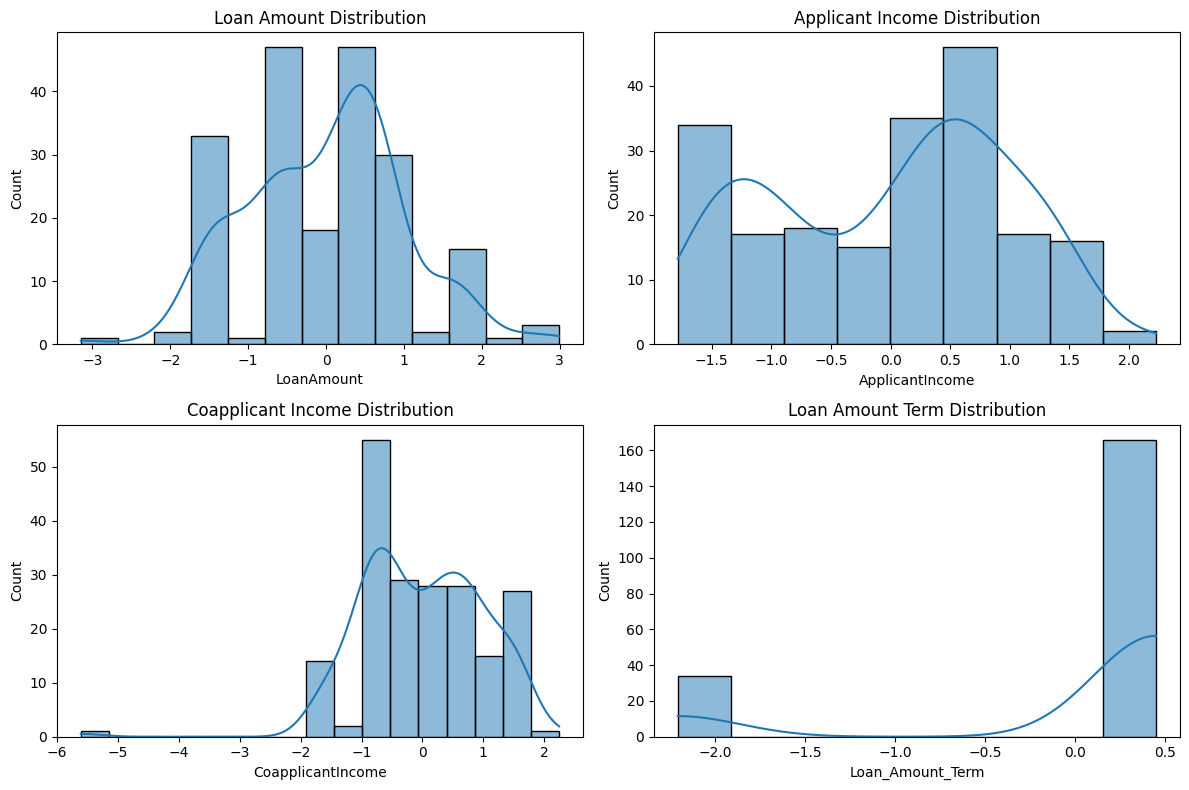

In [8]:
# Plot histograms for numerical features
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(df['LoanAmount'], kde=True)
plt.title('Loan Amount Distribution')

plt.subplot(2, 2, 2)
sns.histplot(df['ApplicantIncome'], kde=True)
plt.title('Applicant Income Distribution')

plt.subplot(2, 2, 3)
sns.histplot(df['CoapplicantIncome'], kde=True)
plt.title('Coapplicant Income Distribution')

plt.subplot(2, 2, 4)
sns.histplot(df['Loan_Amount_Term'], kde=True)
plt.title('Loan Amount Term Distribution')

plt.tight_layout()
plt.show()

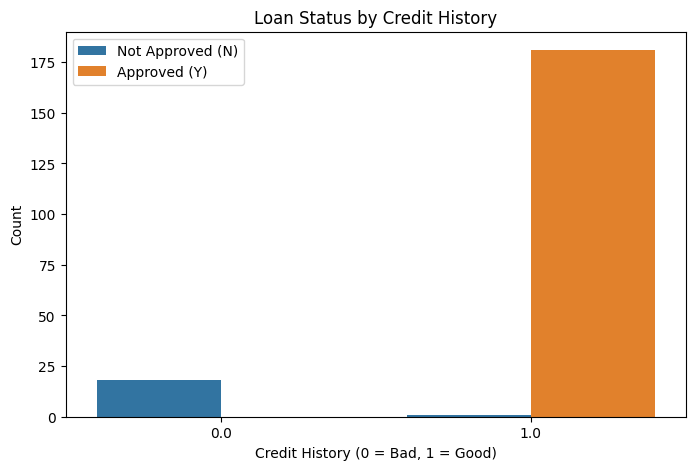

In [9]:
# Plot Loan_Status vs. Credit_History
plt.figure(figsize=(8, 5))
sns.countplot(x='Credit_History', hue='Loan_Status', data=df)
plt.title('Loan Status by Credit History')
plt.xlabel('Credit History (0 = Bad, 1 = Good)')
plt.ylabel('Count')
plt.legend(labels=['Not Approved (N)', 'Approved (Y)'])
plt.show()

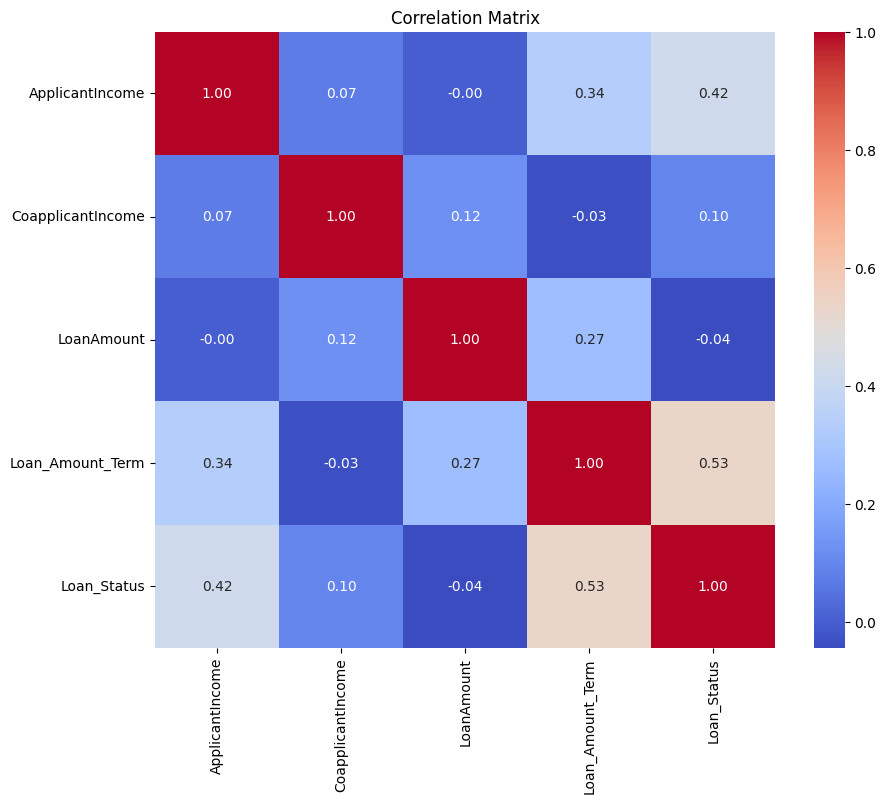

In [10]:
# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols + ['Loan_Status']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [11]:
# Split data into features (X) and target (y)
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes to verify
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (160, 16) (160,)
Testing set shape: (40, 16) (40,)


We’ll split the data into 80% training (to train models) and 20% testing (to evaluate them). The features (X) are all columns except Loan_Status, and the target (y) is Loan_Status.

In [12]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate
    print(f"\nResults for {name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Approved (N)', 'Approved (Y)']))


Results for Logistic Regression:
Accuracy: 1.00
Confusion Matrix:
[[ 4  0]
 [ 0 36]]
Classification Report:
                  precision    recall  f1-score   support

Not Approved (N)       1.00      1.00      1.00         4
    Approved (Y)       1.00      1.00      1.00        36

        accuracy                           1.00        40
       macro avg       1.00      1.00      1.00        40
    weighted avg       1.00      1.00      1.00        40


Results for Decision Tree:
Accuracy: 1.00
Confusion Matrix:
[[ 4  0]
 [ 0 36]]
Classification Report:
                  precision    recall  f1-score   support

Not Approved (N)       1.00      1.00      1.00         4
    Approved (Y)       1.00      1.00      1.00        36

        accuracy                           1.00        40
       macro avg       1.00      1.00      1.00        40
    weighted avg       1.00      1.00      1.00        40


Results for Random Forest:
Accuracy: 1.00
Confusion Matrix:
[[ 4  0]
 [ 0 36]]
Classi

We’ll train three models (Logistic Regression, Decision Tree, Random Forest) and evaluate them using accuracy, confusion matrix, and classification report (precision, recall, F1-score).

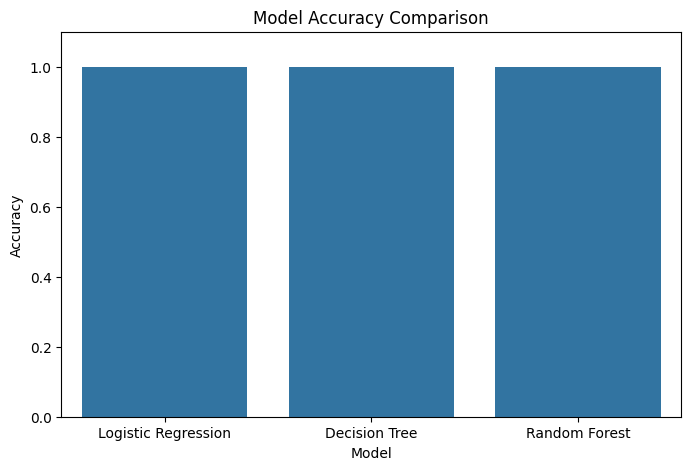


Feature Importance (Random Forest):
                    Feature  Importance
8            Credit_History    0.426109
4           ApplicantIncome    0.171263
7          Loan_Amount_Term    0.081613
5         CoapplicantIncome    0.058619
2                 Education    0.056285
6                LoanAmount    0.055406
15      Property_Area_Urban    0.039501
0                    Gender    0.033599
9              Dependents_0    0.017158
12            Dependents_3+    0.016970
1                   Married    0.011627
11             Dependents_2    0.008404
13      Property_Area_Rural    0.008140
3             Self_Employed    0.007779
14  Property_Area_Semiurban    0.005739
10             Dependents_1    0.001787

Class Balance in Loan_Status:
Loan_Status
1    0.905
0    0.095
Name: proportion, dtype: float64


In [14]:
# Store accuracies for plotting
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']
accuracies = [1.00, 1.00, 1.00]  # From your results

# Plot accuracies
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1.1)  # Slightly above 1 for visibility
plt.show()

# Check feature importance for Random Forest
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance)

# Check class balance in the dataset
print("\nClass Balance in Loan_Status:")
print(df['Loan_Status'].value_counts(normalize=True))

In [15]:
# Check relationship between Credit_History and Loan_Status in training data
print("\nCredit_History vs. Loan_Status in Training Data:")
print(pd.crosstab(y_train, X_train['Credit_History']))

# Train a simple Logistic Regression using only Credit_History
X_train_simple = X_train[['Credit_History']]
X_test_simple = X_test[['Credit_History']]
simple_model = LogisticRegression(max_iter=1000)
simple_model.fit(X_train_simple, y_train)
y_pred_simple = simple_model.predict(X_test_simple)

print("\nSimple Model (Credit_History only) Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_simple):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_simple))


Credit_History vs. Loan_Status in Training Data:
Credit_History  0.0  1.0
Loan_Status             
0                14    1
1                 0  145

Simple Model (Credit_History only) Results:
Accuracy: 1.00
Confusion Matrix:
[[ 4  0]
 [ 0 36]]


In [19]:
import joblib

# Save the Random Forest model
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
joblib.dump(best_model, 'best_loan_model.pkl')

print("Random Forest model saved as 'best_loan_model.pkl'. Download from Colab's Files tab.")

Random Forest model saved as 'best_loan_model.pkl'. Download from Colab's Files tab.


In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

# Load the saved Random Forest model
model = joblib.load('best_loan_model.pkl')

# Load the scaler used during training (from Cell 8)
scaler = StandardScaler()
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
# Fit scaler on training data (assuming X_train is still available from Cell 14)
scaler.fit(X_train[numerical_cols])

# Define feature order (from training data after one-hot encoding)
feature_order = X_train.columns.tolist()

# Function to get and validate user input
def get_user_input():
    print("Enter loan applicant details:")
    try:
        gender = input("Gender (Male/Female): ").strip().capitalize()
        if gender not in ['Male', 'Female']:
            raise ValueError("Gender must be Male or Female")

        married = input("Married (Yes/No): ").strip().capitalize()
        if married not in ['Yes', 'No']:
            raise ValueError("Married must be Yes or No")

        dependents = input("Dependents (0/1/2/3+): ").strip()
        if dependents not in ['0', '1', '2', '3+']:
            raise ValueError("Dependents must be 0, 1, 2, or 3+")

        education = input("Education (Graduate/Not Graduate): ").strip().capitalize()
        if education not in ['Graduate', 'Not Graduate']:
            raise ValueError("Education must be Graduate or Not Graduate")

        self_employed = input("Self Employed (Yes/No): ").strip().capitalize()
        if self_employed not in ['Yes', 'No']:
            raise ValueError("Self Employed must be Yes or No")

        applicant_income = float(input("Applicant Income (e.g., 5000): "))
        if applicant_income < 0:
            raise ValueError("Applicant Income must be non-negative")

        coapplicant_income = float(input("Coapplicant Income (e.g., 1500, enter 0 if none): "))
        if coapplicant_income < 0:
            raise ValueError("Coapplicant Income must be non-negative")

        loan_amount = float(input("Loan Amount (e.g., 150): "))
        if loan_amount <= 0:
            raise ValueError("Loan Amount must be positive")

        loan_amount_term = float(input("Loan Amount Term in months (e.g., 360): "))
        if loan_amount_term <= 0:
            raise ValueError("Loan Amount Term must be positive")

        credit_history = float(input("Credit History (1 for good, 0 for bad): "))
        if credit_history not in [0, 1]:
            raise ValueError("Credit History must be 0 or 1")

        property_area = input("Property Area (Urban/Semiurban/Rural): ").strip().capitalize()
        if property_area not in ['Urban', 'Semiurban', 'Rural']:
            raise ValueError("Property Area must be Urban, Semiurban, or Rural")

        return {
            'Gender': gender,
            'Married': married,
            'Dependents': dependents,
            'Education': education,
            'Self_Employed': self_employed,
            'ApplicantIncome': applicant_income,
            'CoapplicantIncome': coapplicant_income,
            'LoanAmount': loan_amount,
            'Loan_Amount_Term': loan_amount_term,
            'Credit_History': credit_history,
            'Property_Area': property_area
        }
    except ValueError as e:
        print(f"Error: {e}. Please try again.")
        return None

# Get user input
user_data = get_user_input()
if user_data is None:
    print("Prediction aborted due to invalid input.")
else:
    # Create a DataFrame for the input
    input_df = pd.DataFrame([user_data])

    # Encode categorical variables (same as Cell 7)
    le = LabelEncoder()
    input_df['Gender'] = le.fit_transform(input_df['Gender'])  # Male=1, Female=0
    input_df['Married'] = le.fit_transform(input_df['Married'])  # Yes=1, No=0
    input_df['Education'] = le.fit_transform(input_df['Education'])  # Graduate=0, Not Graduate=1
    input_df['Self_Employed'] = le.fit_transform(input_df['Self_Employed'])  # Yes=1, No=0
    input_df = pd.get_dummies(input_df, columns=['Dependents', 'Property_Area'])

    # Ensure all one-hot encoded columns match training data
    for col in feature_order:
        if col not in input_df.columns:
            input_df[col] = 0  # Add missing columns (e.g., Dependents_3+, Property_Area_Rural)
    input_df = input_df[feature_order]  # Reorder columns to match training data

    # Scale numerical features (same as Cell 8)
    input_df[numerical_cols] = scaler.transform(input_df[numerical_cols])

    # Make prediction
    prediction = model.predict(input_df)[0]
    prediction_proba = model.predict_proba(input_df)[0]

    # Display result
    print("\nPrediction Result:")
    print("Loan Status:", "Approved (Y)" if prediction == 1 else "Not Approved (N)")
    print(f"Probability of Approval: {prediction_proba[1]:.2%}")
    print(f"Probability of Non-Approval: {prediction_proba[0]:.2%}")

Enter loan applicant details:
Gender (Male/Female): Male
Married (Yes/No): No
Dependents (0/1/2/3+): 2
Education (Graduate/Not Graduate): Graduate
Self Employed (Yes/No): no
Applicant Income (e.g., 5000): 4500
Coapplicant Income (e.g., 1500, enter 0 if none): 1000
Loan Amount (e.g., 150): 150
Loan Amount Term in months (e.g., 360): 24
Credit History (1 for good, 0 for bad): 1
Property Area (Urban/Semiurban/Rural): Semiurban

Prediction Result:
Loan Status: Approved (Y)
Probability of Approval: 99.00%
Probability of Non-Approval: 1.00%


Testing by giving sample required inputs.